In [1]:
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score # Please note that this is the only sklearn function that can be utilized.
np.random.seed(0)

In [2]:
df_train = pd.DataFrame(pd.read_csv("./PR_HW3_Train.csv"))
df_val   = pd.DataFrame(pd.read_csv("./PR_HW3_Val.csv"))
df_test  = pd.DataFrame(pd.read_csv("./PR_HW3_Test.csv"))

X_train = df_train[['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6', 'Feature7']].to_numpy()
y_train = df_train["Target"].to_numpy().astype(int)

X_val = df_val[['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6', 'Feature7']].to_numpy()
y_val = df_val["Target"].to_numpy()

X_test = df_test[['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6', 'Feature7']].to_numpy()
y_test = df_test["Target"].to_numpy()

In [3]:
def entropy(examples):
    unique, counts = np.unique(examples, return_counts=True)
    probs = counts / len(examples)
    return -np.sum(probs * np.log2(probs))

def gini(examples):
    unique, counts = np.unique(examples, return_counts=True)
    probs = counts / len(examples)
    return 1 - np.sum(probs**2)

In [4]:
ex1 = np.array(["+", "+", "+", "+", "+", "-"])
ex2 = np.array(["+", "+", "+", "-", "-", "-"])
ex3 = np.array(["+" ,"-", "-", "-", "-", "-"])
print(f"{ex1}: entropy = {entropy(ex1)}\n{ex2}: entropy = {entropy(ex2)}\n{ex3}: entropy = {entropy(ex3)}\n")
print(f"{ex1}: gini index = {gini(ex1)}\n{ex2}: gini index = {gini(ex2)}\n{ex3}: gini index = {gini(ex3)}\n")

['+' '+' '+' '+' '+' '-']: entropy = 0.6500224216483541
['+' '+' '+' '-' '-' '-']: entropy = 1.0
['+' '-' '-' '-' '-' '-']: entropy = 0.6500224216483541

['+' '+' '+' '+' '+' '-']: gini index = 0.2777777777777777
['+' '+' '+' '-' '-' '-']: gini index = 0.5
['+' '-' '-' '-' '-' '-']: gini index = 0.2777777777777777



In [5]:
class ClassifyNode:
    # ClassidyNode class contains child nodes, best threshold and best feature for splitting
    
    def __init__(self, feature=None, threshold=None, l_node=None, r_node=None, mark=None):
        self.feature = feature # idx of feature for splitting
        self.threshold = threshold # threshold value for splitting
        self.l_node = l_node # left ClassifyNode object 
        self.r_node = r_node # right ClassifyNode object 
        self.mark = mark # if it is a leaf node, it gets a class mark 
    def is_leaf_node(self):
        return self.mark is not None
        
class MyDecisionTreeClassifier:
    
    def __init__(self, criterion="gini", min_samples_split=2, max_depth="inf", n_feats=None, randomSet= True):
            self.min_samples_split = min_samples_split
            self.max_depth = max_depth
            self.n_feats = n_feats
            self.root = None
            self.criterion = criterion
            self.feature_counts = None
            self.randomSet = randomSet
        
    def fit(self, X, y):
        self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats, X.shape[1])
        # avoid situation when n_feats > real number of features 
        self.root = self._build_node(X, y)
        # The first node for splitting

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])
        # see _traverse_tree function

    def _traverse_tree(self, x, node):
        if node.is_leaf_node(): # if current node is terminal then return class with biggest occurrence level
            return node.mark
        if x[node.feature] <= node.threshold: # chek feature in this node and compare node threshold with feature value in x 
            return self._traverse_tree(x, node.l_node)# send x to child node until it gets the leaf node
        return self._traverse_tree(x, node.r_node)
    
    def _compute_gini(self, y):
        _, counts = np.unique(y, return_counts=True)
        proportions = counts / y.size
        return 1 - np.sum(proportions**2)

    def _compute_entropy(self, y):
        _, counts = np.unique(y, return_counts=True)
        proportions = counts / y.size
        return -np.sum(proportions * np.log2(proportions))
    
    def _build_node(self, X, y, depth=0):
        n_samples, n_features = X.shape # in arrays and Dataframes shapes are in format (n_samples, n_features)
        n_labels = len(np.unique(y)) # array of unique classes
        
        # check stopping criteria (max_depth & min_samples_split)
        if (self.max_depth is not None and depth >= self.max_depth) or n_labels == 1 or n_samples < self.min_samples_split:
            leaf_mark = self._most_encountered_mark(y)
            return ClassifyNode(mark=leaf_mark)
        if self.randomSet:
            feature_idxs = np.random.choice(n_features, self.n_feats, replace=False) # if we decided to choose a subset of features
        else:
            feature_idxs = np.arange(n_features)
        best_feature, best_thresh = self._best_split(X, y, feature_idxs)# see _best_split()
        
        if self.feature_counts is None:
            self.feature_counts = np.zeros(X.shape[1], dtype=int)
        self.feature_counts[best_feature] += 1
        
        left_idxs, right_idxs = self._split(X[:, best_feature], best_thresh)# see _split()
        left = self._build_node(X[left_idxs, :], y[left_idxs], depth+1)
        right = self._build_node(X[right_idxs, :], y[right_idxs], depth+1)
        # after we find best split, we give left data and right data to child nodes
        
        return ClassifyNode(best_feature, best_thresh, left, right)
        
    def _best_split(self, X, y, feature_idxs):
        best_information_gain = -1
        split_idx, split_thresh = None, None
        for idx in feature_idxs: # for each feature
            X_column=X[:, idx] # take all values in this features
            thresholds = np.unique(X_column) # drop similar values
            for threshold in thresholds: # for each unique value
                gain = self._information_gain(y, X_column, threshold) # see _information_gain()
                if gain > best_information_gain:
                    best_information_gain = gain
                    split_idx = idx
                    split_thresh = threshold
                # save information gain in case it better than previous
                    
        return split_idx, split_thresh
    
    def _information_gain(self, y, X_column, split_thresh):
        if self.criterion == "gini":
            parent_impurity = self._compute_gini(y) # use Gini impurity
        elif self.criterion == "entropy":
            parent_impurity = self._compute_entropy(y) # use entropy
        else:
            raise ValueError("Invalid criterion, choose either 'gini' or 'entropy'.")
        left_idxs, right_idxs = self._split(X_column, split_thresh) # see _split()
        if len(left_idxs) == 0 or len(right_idxs) == 0: # check if we splitted nothing
            return 0

        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        # number of samples in left and right nodes
        if self.criterion == "gini":
            impurity_l, impurity_r = self._compute_gini(y[left_idxs]), self._compute_gini(y[right_idxs])
        elif self.criterion == "entropy":
            impurity_l, impurity_r = self._compute_entropy(y[left_idxs]), self._compute_entropy(y[right_idxs])
        
        child_impurity = (n_l/n)*impurity_l + (n_r/n)*impurity_r # weighted sum of left and right child
        info_gain = parent_impurity - child_impurity # finally calculated information gain 
        
        return info_gain
    
    
    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        
        return left_idxs, right_idxs

    def _most_encountered_mark(self, y):
        most_encountered = np.argmax(np.bincount(y))
        return most_encountered
    
    def get_feature_importance(self):
        if self.feature_counts is None:
            raise ValueError("Feature importance is not available before fitting the model.")
        total_splits = np.sum(self.feature_counts)
        return self.feature_counts / total_splits

    def plot_feature_importance(self, feature_names=None):
        importance = self.get_feature_importance()

        if feature_names is None:
            feature_names = [f"Feature {i+1}" for i in range(importance.size)]
        idx = np.argsort(importance)
        feature_names = np.array(feature_names)
        plt.barh(feature_names[idx], importance[idx])
        plt.xlabel("Importance")
        plt.ylabel("Features")
        plt.title("Feature Importance")
        plt.show()

In [6]:
class RandomForestClassifier:
    def __init__(self, n_estimators=100, max_features=None, bootstrap=True, criterion="gini", max_depth = None, randomSet = False):
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.bootstrap = bootstrap
        self.criterion = criterion
        self.max_depth = max_depth
        self.trees = []
        self.randomSet = randomSet

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_estimators):
            tree = MyDecisionTreeClassifier(criterion= self.criterion, max_depth= self.max_depth, n_feats= self.max_features, randomSet= self.randomSet)
            if self.bootstrap:
                X_sample, y_sample = self._bootstrap_sample(X, y)
            else:
                X_sample, y_sample = X, y
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def _bootstrap_sample(self, X, y):
        indices = np.random.choice(X.shape[0], size=int(X.shape[0]), replace=True)
        return X[indices], y[indices]

    def predict(self, X):
        tree_predictions = np.array([tree.predict(X) for tree in self.trees])
        return np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=tree_predictions)

In [7]:
Tree = MyDecisionTreeClassifier(criterion= "gini", max_depth=3, n_feats= None)
Tree.fit(X_train, y_train)
acc = accuracy_score(y_val, Tree.predict(X_val))
print(f'Q2-1 max_depth= 3: {acc:.2f}')

Tree = MyDecisionTreeClassifier(criterion= "gini", max_depth=10, n_feats= None)
Tree.fit(X_train, y_train)
acc = accuracy_score(y_val, Tree.predict(X_val))
print(f'Q2-2 max_depth= 10: {acc:.2f}')

Tree = MyDecisionTreeClassifier(criterion= "gini", max_depth=3, n_feats= None)
Tree.fit(X_train, y_train)
acc = accuracy_score(y_val, Tree.predict(X_val))
print(f'Q3-1 criterion= gini: {acc:.2f}')

Tree = MyDecisionTreeClassifier(criterion= "entropy", max_depth=3, n_feats= None)
Tree.fit(X_train, y_train)
acc = accuracy_score(y_val, Tree.predict(X_val))
print(f'Q3-2 criterion= entropy: {acc:.2f}')

# For Q2-1, validation accuracy should be higher than or equal to 0.73
# For Q2-2, validation accuracy should be higher than or equal to 0.85
# For Q3-1, validation accuracy should be higher than or equal to 0.73
# For Q3-2, validation accuracy should be higher than or equal to 0.77

Q2-1 max_depth= 3: 0.73
Q2-2 max_depth= 10: 0.86
Q3-1 criterion= gini: 0.73
Q3-2 criterion= entropy: 0.77


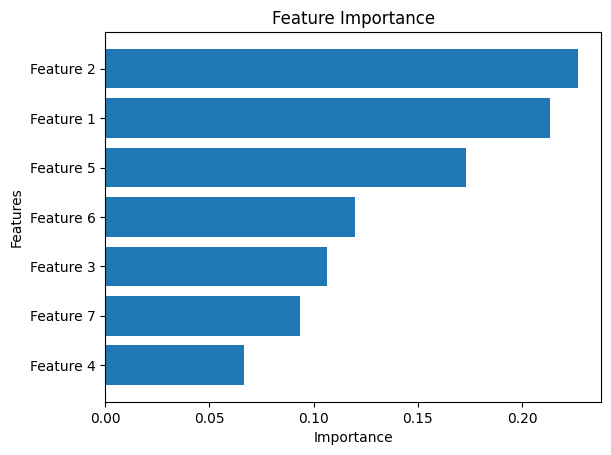

In [8]:
np.random.seed(0)
Tree = MyDecisionTreeClassifier(criterion= "gini", max_depth=10, n_feats=None)
Tree.fit(X_train, y_train)
acc = accuracy_score(y_val, Tree.predict(X_val))
Tree.plot_feature_importance()

In [9]:
np.random.seed(1)
rf_estimators10 = RandomForestClassifier(n_estimators=10, max_features=int(np.sqrt(X_train.shape[1])), bootstrap=True
                                         , criterion='gini', max_depth=None)
rf_estimators10.fit(X_train, y_train)
acc = accuracy_score(y_val, rf_estimators10.predict(X_val))
print(f'Q5-1 n_estimators=10: {acc:.2f}')
# For Q5-1, validation accuracy should be higher than or equal to 0.88

Q5-1 n_estimators=10: 0.88


In [10]:
np.random.seed(1)
rf_estimators10 = RandomForestClassifier(n_estimators=50, max_features=int(np.sqrt(X_train.shape[1])), bootstrap=True
                                         , criterion='gini', max_depth=None)
rf_estimators10.fit(X_train, y_train)
acc = accuracy_score(y_val, rf_estimators10.predict(X_val))
print(f'Q5-2 n_estimators=50: {acc:.2f}')
# For Q5-2, validation accuracy should be higher than or equal to 0.89

Q5-2 n_estimators=50: 0.89


In [11]:
np.random.seed(0)
rf_estimators10 = RandomForestClassifier(n_estimators=10, max_features=int(np.sqrt(X_train.shape[1])), bootstrap=True
                                         , criterion='gini', max_depth=None)
rf_estimators10.fit(X_train, y_train)
acc = accuracy_score(y_val, rf_estimators10.predict(X_val))
print(f'Q6-1 max_features= sqrt: {acc:.2f}')
# For Q6-1, validation accuracy should be higher than or equal to 0.88

Q6-1 max_features= sqrt: 0.88


In [12]:
np.random.seed(0)
rf_estimators10 = RandomForestClassifier(n_estimators=10, max_features=None, bootstrap=True, criterion='gini', max_depth=None)
rf_estimators10.fit(X_train, y_train)
acc = accuracy_score(y_val, rf_estimators10.predict(X_val))
print(f'Q6-2 max_features= None: {acc:.2f}')
# For Q7-2, validation accuracy should be higher than or equal to 0.86

Q6-2 max_features= None: 0.88


In [13]:
np.random.seed(2)
rf_estimators80 = RandomForestClassifier(n_estimators=80, max_features= 3, bootstrap=True, criterion='gini', max_depth=None, randomSet = True)
rf_estimators80.fit(X_train, y_train)
acc = accuracy_score(y_val, rf_estimators80.predict(X_val))
print(f'Q7 n_estimators= 80: {acc}')

Q7 n_estimators= 80: 0.9


In [14]:
df_test = pd.DataFrame(pd.read_csv("./PR_HW3_Test.csv"))
test_pred = rf_estimators80.predict(X_test)
df_test["Target"] = test_pred
df_test.to_csv("411551005_prediction.csv")